In [1]:
# load libs 

import pickle
import os
import csv
import numpy as np
import sys
import random
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import re
sys.path.append(r'/home/stud/afroehli/coding/util_scripts')
from utils_dataloading.imagenet_tree import ImagenetSemanticInfo, ImagenetSemanticSubtree

In [2]:
# objects of general use

imagenet_info = ImagenetSemanticInfo()

Stop node discovered


In [3]:
# define paths to load

root_path = '/home/stud/afroehli/coding/model_results/dinov2_vits14/'

inet_1k_val_path = (root_path + 'inet_1k_val_timm_trans.pkl', 'inet_1k_val')
inet_v2_70_path = (root_path + 'inet_v2_70_timm_trans.pkl', 'inet_v2_70')
inet_v2_mf_path = (root_path + 'inet_v2_mf_timm_trans.pkl', 'inet_v2_mf')
inet_v2_top_path = (root_path + 'inet_v2_top_timm_trans.pkl', 'inet_v2_top')
inet_r_path = (root_path + 'inet_r_plus_pt_timm_trans.pkl', 'inet_r')

loading_paths = [inet_1k_val_path, inet_v2_70_path, inet_v2_mf_path, inet_v2_top_path, inet_r_path]

inet_c_basepath = root_path + 'imagenet_c'
inet_c_corruptions = os.listdir(inet_c_basepath)


In [4]:
# return dict only with cls-token from dict that holds pt-tokens + cls-token 

def cls_tokens_from_cls_plus_pt_tokens(cls_plus_pt_tokens: dict) -> dict:
    just_cls_tokens = dict()
    for class_wnid in cls_plus_pt_tokens.keys():
        just_cls_tokens[class_wnid] = [np.squeeze(cls_plus_pt[3][1]) for cls_plus_pt in cls_plus_pt_tokens[class_wnid]]

    return just_cls_tokens 

def get_cls_token_single_layer(cls_plus_pt_token: dict) -> dict: 
    just_cls_token = dict()
    for class_wnid in cls_plus_pt_token.keys():
        just_cls_token[class_wnid] = [np.squeeze(cls_plus_pt[1]) for cls_plus_pt in cls_plus_pt_token[class_wnid]]
    return just_cls_token


In [5]:
# load pre-computed embeddings 

model_results = dict()

# first all simple datasets
for load_path, dict_name in loading_paths:
    with open(load_path, 'rb') as pkl_file:
        if dict_name == 'inet_r':
            model_results[dict_name] = cls_tokens_from_cls_plus_pt_tokens(pickle.load(pkl_file))
        else:
            model_results[dict_name] = pickle.load(pkl_file)


# then all variations of imagenet-c
# model_results['inet_c'] = dict()
# for corruption in inet_c_corruptions:
#     for sev_n in range(1, 6):
#         if sev_n == 1: 
#             model_results['inet_c'][corruption] = dict()

#         with open(f'{inet_c_basepath}/{corruption}/sev_{sev_n}.pkl', 'rb') as pkl_file:
#             inet_c_results_dict = pickle.load(pkl_file)
#             wnid_list = list(inet_c_results_dict.keys())
#             model_results['inet_c'][corruption][sev_n] = get_cls_token_single_layer(inet_c_results_dict)
            
#             assert len(model_results['inet_c'][corruption][sev_n]) == len(wnid_list)
#             for wnid in wnid_list:
#                 assert len(model_results['inet_c'][corruption][sev_n][wnid]) == 50 

    

In [6]:
def calc_l1_dist(emb_one: np.array, emb_two: np.array) -> float :
    return np.sum(np.abs(emb_one - emb_two))

def count_dims_nearer_than_comp_embedding(emb_fixed: np.array, emb_class: np.array, emb_comp: np.array) -> float: 
    return (np.abs(emb_class - emb_fixed) < np.abs(emb_comp - emb_fixed)).tolist().count(True) 

def count_dims_within_stddev(emb_fixed_mean: np.array, emb_fixed_stddev: np.array, emb_class: np.array) -> float:
    return (np.abs(emb_fixed_mean - emb_class) <= emb_fixed_stddev).tolist().count(True) 

def count_dims_exclusive_within_stddev(emb_fixed_mean: np.array, emb_fixed_stddev: np.array, emb_class_in: np.array, emb_class_out: np.array) -> float:
    abs_dist_in = np.abs(emb_class_in - emb_fixed_mean)
    abs_dist_out = np.abs(emb_class_out - emb_fixed_mean)
    return np.logical_and((abs_dist_in <= emb_fixed_stddev), (abs_dist_out >= emb_fixed_stddev)).tolist().count(True)

In [7]:
# for each of the used 4 distance measures, calculate distance of mean embedding of each remaining id-class to class-a embedding 

class_a_wnids = set(model_results['inet_r'].keys()) 
print(len(class_a_wnids))

inet_1k_val_stats = dict()
inet_1k_wnids = set(model_results['inet_1k_val'].keys())

class_a_distances = {'l1_dist': dict(), 'count_dims_nearer': dict(), 'count_within_stddev': dict(), 'count_excl_within_stddev': dict()}

for wnid in inet_1k_wnids:
    inet_1k_val_stats[wnid] = dict()
    inet_1k_val_stats[wnid]['mean'] = np.mean(np.array(model_results['inet_1k_val'][wnid]), axis=0)
    inet_1k_val_stats[wnid]['stddev'] = np.std(np.array(model_results['inet_1k_val'][wnid]), axis=0)

# mean embedding of all ImageNet-1k samples
inet_1k_all_embeds = []
for wnid in model_results['inet_1k_val'].keys():
    inet_1k_all_embeds.extend(model_results['inet_1k_val'][wnid])
inet_1k_mean = np.mean(np.array(inet_1k_all_embeds), axis = 0)

# for each common wnid, calculate distance to remaining 999 wnids
for class_a in class_a_wnids:

    inet_1k_wnids.remove(class_a)

    for wnid in inet_1k_wnids:
        l1_dist = calc_l1_dist(inet_1k_val_stats[class_a]['mean'], inet_1k_val_stats[wnid]['mean'])
        counts_dims_nearer = count_dims_nearer_than_comp_embedding(inet_1k_val_stats[class_a]['mean'], inet_1k_val_stats[wnid]['mean'], inet_1k_mean)
        within_stddev = count_dims_within_stddev(inet_1k_val_stats[class_a]['mean'], inet_1k_val_stats[class_a]['stddev'], 
                                                 inet_1k_val_stats[wnid]['mean'])
        excl_within_stddev = count_dims_exclusive_within_stddev(inet_1k_val_stats[class_a]['mean'], inet_1k_val_stats[class_a]['stddev'], 
                                                                inet_1k_val_stats[wnid]['mean'], inet_1k_mean)

        try: 
            class_a_distances['l1_dist'][class_a].append((wnid, l1_dist))
            class_a_distances['count_dims_nearer'][class_a].append((wnid, counts_dims_nearer))
            class_a_distances['count_within_stddev'][class_a].append((wnid, within_stddev))
            class_a_distances['count_excl_within_stddev'][class_a].append((wnid, excl_within_stddev))
        except KeyError:
            class_a_distances['l1_dist'][class_a] = [(wnid, l1_dist)]
            class_a_distances['count_dims_nearer'][class_a] = [(wnid, counts_dims_nearer)]
            class_a_distances['count_within_stddev'][class_a] = [(wnid, within_stddev)]
            class_a_distances['count_excl_within_stddev'][class_a] = [(wnid, excl_within_stddev)]

    class_a_distances['l1_dist'][class_a].sort(key = lambda la: la[1])
    class_a_distances['count_dims_nearer'][class_a].sort(key = lambda la: la[1], reverse=True)
    class_a_distances['count_within_stddev'][class_a].sort(key = lambda la: la[1], reverse=True)
    class_a_distances['count_excl_within_stddev'][class_a].sort(key = lambda la: la[1], reverse=True)
    inet_1k_wnids.add(class_a)

print(class_a_distances['l1_dist']['n07714571'])

200
[('n04286575', np.float32(543.31885)), ('n03991062', np.float32(550.6557)), ('n03958227', np.float32(558.0752)), ('n03461385', np.float32(563.4634)), ('n07860988', np.float32(569.923)), ('n04525038', np.float32(575.2582)), ('n02206856', np.float32(576.1066)), ('n03803284', np.float32(576.29193)), ('n07715103', np.float32(577.65936)), ('n04476259', np.float32(578.7903)), ('n04522168', np.float32(579.3364)), ('n04235860', np.float32(581.7506)), ('n03028079', np.float32(582.2566)), ('n03976657', np.float32(585.2641)), ('n03045698', np.float32(585.2869)), ('n02930766', np.float32(586.7052)), ('n04332243', np.float32(587.3778)), ('n03770679', np.float32(588.84033)), ('n04141975', np.float32(590.87683)), ('n07579787', np.float32(591.0227)), ('n03692522', np.float32(593.4004)), ('n03871628', np.float32(594.5808)), ('n07753113', np.float32(595.7256)), ('n04357314', np.float32(596.3596)), ('n03400231', np.float32(598.57336)), ('n03796401', np.float32(599.5343)), ('n03124170', np.float32(599

In [25]:
# store dict with all distances to class-a 

with open('/home/stud/afroehli/coding/dinov2_ood/storage/class_a_distances.pkl', 'wb') as pkl_fl: 
    pickle.dump(class_a_distances, pkl_fl, pickle.HIGHEST_PROTOCOL)

# for each class-a store nearest class-b according to: l1-dist, count-dims-nearest, within_stddev, within-excl-stddev 
with open('/home/stud/afroehli/coding/dinov2_ood/storage/class_a_classes_b.csv', 'w', newline='') as nearest_classes_table: 
    csv_writer = csv.writer(nearest_classes_table, delimiter=';')
    csv_writer.writerow(['Class-A', 'Class-B-L1', 'Class-B-dims-nearer', 'Class-B-within-stddev', 'Class-B-excl-within-stddev'])

    for class_a_wnid in class_a_wnids:
        class_b_l1 = class_a_distances['l1_dist'][class_a_wnid][0][0]
        class_b_count_dims_nearer = class_a_distances['count_dims_nearer'][class_a_wnid][0][0]
        class_b_count_within_stddev = class_a_distances['count_within_stddev'][class_a_wnid][0][0]
        class_b_count_excl_within_stddev = class_a_distances['count_excl_within_stddev'][class_a_wnid][0][0]

        csv_writer.writerow([class_a_wnid, class_b_l1, class_b_count_dims_nearer, class_b_count_within_stddev, class_b_count_excl_within_stddev])


In [8]:
# load mapping of class-a to list of classes-b

class_a_to_class_b_mapping = dict()

with open('/home/stud/afroehli/coding/dinov2_ood/storage/class_a_classes_b.csv', 'r') as nearest_classes_table:
    class_mapping = csv.reader(nearest_classes_table, delimiter=';')

    skip_heading = True 
    for class_a_b_mapping in class_mapping:
        if skip_heading:
            print(class_a_b_mapping)
            skip_heading = False 
        else: 
            class_a = class_a_b_mapping[0]
            classes_b = [class_a_b_mapping[n] for n in range(1, 5)]
            class_a_to_class_b_mapping[class_a] = classes_b 

test = list(class_a_to_class_b_mapping.keys())[0]
print(class_a_to_class_b_mapping[test])


['Class-A', 'Class-B-L1', 'Class-B-dims-nearer', 'Class-B-within-stddev', 'Class-B-excl-within-stddev']
['n03063599', 'n03063599', 'n07932039', 'n03063599']


In [4]:
# write explict class-names of [class-A; [classes-B]] in csv-file 

with open('/home/stud/afroehli/coding/dinov2_ood/storage/class_a_classes_b_inet_names.csv', 'w', newline='') as nearest_classes_table: 
    csv_writer = csv.writer(nearest_classes_table, delimiter=';')
    csv_writer.writerow(['Class-A', 'Class-B-L1', 'Class-B-dims-nearer', 'Class-B-within-stddev', 'Class-B-excl-within-stddev'])
    for class_a_wnid in class_a_to_class_b_mapping.keys():
        class_names = [imagenet_info.wnid_to_classname[class_a_wnid]]
        class_names.extend([imagenet_info.wnid_to_classname[class_b_wnid] for class_b_wnid in class_a_to_class_b_mapping[class_a_wnid]])
        if class_a_wnid == 'n07714571':
            print(f'{class_a_wnid}: {class_a_to_class_b_mapping[class_a_wnid]}')
            print(class_names)
        # csv_writer.writerow(class_names)

n07714571: ['n04286575', 'n03991062', 'n02206856', 'n07715103']
[' cabbage', ' spotlight', ' plant pot', ' bee', ' cauliflower']


In [ ]:
# store pictures for example comparison sequence used in thesis 



In [3]:
# common selections of class-b among 4 different measures 

# for each list with 4 different class-b instantiations
# choose pairs of two: 3 x 2 x 1 = 6 pairs, (1, 2), (1,3), (1, 4), (2, 3), (2,4), (3,4)  
# only increment when values for x and y in (x, y) are different 

comp_pairs = {(0, 1): 0, (0, 2): 0, (0, 3): 0, (1, 2): 0, (1, 3): 0, (2, 3): 0} 
for class_a_wnid in class_a_to_class_b_mapping.keys():
    classes_b = class_a_to_class_b_mapping[class_a_wnid]
    for pair_pos in comp_pairs.keys():
        if classes_b[pair_pos[0]] != classes_b[pair_pos[1]]:
            comp_pairs[pair_pos] += 1 

print(comp_pairs)

{(0, 1): 23, (0, 2): 33, (0, 3): 69, (1, 2): 39, (1, 3): 77, (2, 3): 72}


In [ ]:
# check for deviations of class-B across distance measures
# for each method to derive class-B, check if a different Imagenet class for class-B was used 

different_class_b = {'count_dims_nearer': 0, 'count_within_stddev': 0, 'count_excl_within_stddev': 0}

for class_a in class_a_wnids:
    for measure in different_class_b.keys():
        if class_a_distances['l1_dist'][class_a][0][0] != class_a_distances[measure][class_a][0][0]:
            different_class_b[measure] += 1 

print(different_class_b)

{'count_dims_nearer': 21, 'count_within_stddev': 32, 'count_excl_within_stddev': 67}


In [10]:
# for each inet-r class find closest inet-1k-class

inet_r_mean = dict()
for wnid in class_a_wnids:
    inet_r_mean[wnid] = np.mean(np.array(model_results['inet_r'][wnid]), axis=0)

inet_r_dist = dict()

for class_a_wnid in class_a_wnids:
    for inet_wnid in inet_1k_wnids:
        try:
            inet_r_dist[class_a_wnid].append((inet_wnid, np.sum(np.abs(np.array(inet_r_mean[class_a_wnid]) - inet_1k_val_mean[inet_wnid]))))
        except KeyError:
            inet_r_dist[class_a_wnid] = [((inet_wnid, np.sum(np.abs(np.array(inet_r_mean[class_a_wnid]) - inet_1k_val_mean[inet_wnid]))))]

    inet_r_dist[class_a_wnid].sort(key=lambda x: x[1])



NameError: name 'inet_1k_val_mean' is not defined

In [6]:
# store class split 

with open('/home/stud/afroehli/coding/dinov2_ood/storage/class_a_class_b_timm_trans.csv', 'w', newline='') as class_split_table:
    split_writer = csv.writer(class_split_table, delimiter=';')

    for class_a in class_a_wnids:
        closest_class_wnid = class_a_distances[class_a][0][0]
        split_writer.writerow([class_a, closest_class_wnid])

In [7]:
with open('/home/stud/afroehli/coding/dinov2_ood/storage/inet_r_neares_inet_1k.csv', 'w', newline='') as class_split_table:
    split_writer = csv.writer(class_split_table, delimiter=';')

    for class_a in class_a_wnids:
        closest_class_name = imagenet_info.wnid_to_classname[inet_r_dist[class_a][0][0]]
        class_a_name = imagenet_info.wnid_to_classname[class_a]
        class_b_name = imagenet_info.wnid_to_classname[class_a_distances[class_a][0][0]]
        split_writer.writerow([class_a_name, closest_class_name, class_b_name])

In [11]:
class_a_b_map = dict()

with open('/home/stud/afroehli/coding/dinov2_ood/storage/class_a_class_b_timm_trans.csv', 'r') as class_split_table:
    closest_pairs_timm_trans = csv.reader(class_split_table, delimiter=';')

    for class_a, class_b in closest_pairs_timm_trans:
        class_a_b_map[class_a] = class_b


In [ ]:
with open('/home/stud/afroehli/coding/dinov2_ood/storage/class_split.csv', 'r') as class_split_table:
    closest_pairs_old = csv.reader(class_split_table, delimiter=';')
    for class_a_old, class_b_old in closest_pairs_old:

        if class_a_b_map[class_a_old] != class_b_old:
            #print(f'Different class-B for: {class_a_old}, New = {class_a_b_map[class_a_old]}, Old = {class_b_old}')
            class_a_name = imagenet_info.wnid_to_classname[class_a_old]
            class_b_new_name = imagenet_info.wnid_to_classname[class_a_b_map[class_a_old]]
            class_b_old_name = imagenet_info.wnid_to_classname[class_b_old]
            print(f'Class-A: {class_a_name}, Class-B-Old: {class_b_old_name}, Class-B-New: {class_b_new_name}')

In [9]:
pat_first = re.compile('i.*not.*')
pat_second = re.compile('not.*and.*')
pat_both = re.compile('i.*and.*')
pat_none = re.compile('not.*not.*')

def calculate_in_stddev_stats(class_X_mean: np.array, store_dict: dict, class_a_mean, class_a_stddev, inet_1k_mean):

        inet_1k_class_a_dist = np.abs(inet_1k_mean - class_a_mean)
        class_X_class_a_dist = np.abs(class_X_mean - class_a_mean)

        for log_case in ['in_not_inet_mean', 'in_and_inet_mean', 'not_in_and_inet_mean', 'not_in_not_inet_mean']:


            if pat_first.fullmatch(log_case):
                store_dict[log_case] = np.logical_and((class_X_class_a_dist <= class_a_stddev), 
                                                                            (inet_1k_class_a_dist > class_a_stddev)).tolist().count(True)
            elif pat_second.fullmatch(log_case):
                store_dict[log_case] = np.logical_and((class_X_class_a_dist > class_a_stddev), 
                                                                (inet_1k_class_a_dist <= class_a_stddev)).tolist().count(True)
            elif pat_both.fullmatch(log_case):
                store_dict[log_case] = np.logical_and((class_X_class_a_dist <= class_a_stddev), 
                                                                (inet_1k_class_a_dist <= class_a_stddev)).tolist().count(True)
            elif pat_none.fullmatch(log_case):
                store_dict[log_case] = np.logical_and((class_X_class_a_dist > class_a_stddev), 
                                                                (inet_1k_class_a_dist > class_a_stddev)).tolist().count(True)
            else:
                raise ValueError(f'Logical case *{log_case}* was not matched')

In [10]:
## calculate statistics 

# fixed order of inet-wnids
inet_wnids_static = []

with open('/home/stud/afroehli/coding/dinov2_ood/storage/imagenet_train_class_to_index_mapping.csv', 'r') as class_index_table:
    class_index_reader = csv.reader(class_index_table, delimiter=';')
    for inet_class, _ in class_index_reader: 
        inet_wnids_static.append(inet_class)

stats_dict = dict()
random.seed(7)

# generate tuples of inet-wnids to compare 
compare_sets = []
for class_a in class_a_to_class_b_mapping.keys():
    classes_b = class_a_to_class_b_mapping[class_a]

    rand_wnid = inet_wnids_static[random.randrange(0, len(inet_wnids_static))]
    while rand_wnid == class_a or rand_wnid in classes_b:
        rand_wnid = inet_wnids_static[random.randrange(0, len(inet_wnids_static))]

    compare_sets.append((class_a, classes_b, rand_wnid))

# whole imagenet-1k 
inet_1k_all_embeds = []
for wnid in inet_wnids_static:
    inet_1k_all_embeds.extend(model_results['inet_1k_val'][wnid])

inet_1k_mean = np.mean(np.array(inet_1k_all_embeds), axis = 0)

class_b_measures = ['l1_dist', 'count_dims_nearer', 'count_in_stddev', 'count_excl_in_stddev']

# over all class pairs: classA, classB, classRandom
for class_a, classes_b, class_rand in compare_sets:

    comb_key = (class_a, tuple(classes_b), class_rand)
    stats_dict[comb_key] = {'dim_nearer': {'inet_c': dict()}, 'l1_dist': {'inet_c': dict()}, 'dim_std': {'inet_c': dict()}}

    class_a_mean = np.mean(np.array(model_results['inet_1k_val'][class_a]), axis=0)
    class_a_stddev = np.std(np.array(model_results['inet_1k_val'][class_a]), axis=0)
    class_r_mean = np.mean(np.array(model_results['inet_1k_val'][class_rand]), axis=0)

    classes_b_means = dict() 
    for measure, class_b in zip(class_b_measures, classes_b):
        classes_b_means[measure] = np.mean(np.array(model_results['inet_1k_val'][class_b]), axis=0)
    

    # measurement 1: dims nearer than inet-mean
    stats_dict[comb_key]['dim_nearer']['class_b'] = dict()
    for measure in classes_b_means.keys():
        class_b_mean = classes_b_means[measure]
        stats_dict[comb_key]['dim_nearer']['class_b'][measure] = (np.abs(class_b_mean - class_a_mean) < np.abs(inet_1k_mean - class_a_mean)).tolist().count(True)
    stats_dict[comb_key]['dim_nearer']['class_r'] = (np.abs(class_r_mean - class_a_mean) < np.abs(inet_1k_mean - class_a_mean)).tolist().count(True)

    # measurement 2: l1-distance
    stats_dict[comb_key]['l1_dist']['inet_mean'] = np.sum(np.abs(inet_1k_mean - class_a_mean))
    stats_dict[comb_key]['l1_dist']['class_b'] = dict()
    for measure in classes_b_means.keys():
        class_b_mean = classes_b_means[measure]
        stats_dict[comb_key]['l1_dist']['class_b'][measure] = np.sum(np.abs(class_b_mean - class_a_mean))
    stats_dict[comb_key]['l1_dist']['class_r'] = np.sum(np.abs(class_r_mean - class_a_mean))

    # measurement 3: dims in std-dev of class-a
    stats_dict[comb_key]['dim_std']['class_b'] = dict()
    for measure in class_b_measures:
        stats_dict[comb_key]['dim_std']['class_b'][measure] = dict()
        class_mean = classes_b_means[measure]
        calculate_in_stddev_stats(class_mean, stats_dict[comb_key]['dim_std']['class_b'][measure], 
                                  class_a_mean, class_a_stddev, inet_1k_mean)
        
    stats_dict[comb_key]['dim_std']['class_r'] = dict()
    calculate_in_stddev_stats(class_r_mean, stats_dict[comb_key]['dim_std']['class_r'], 
                                class_a_mean, class_a_stddev, inet_1k_mean)

   
    for res_key in ['inet_v2_70', 'inet_v2_mf', 'inet_v2_top', 'inet_r']:

        if res_key == 'inet_r_orig':
            pass 
        
        class_var_mean = np.mean(np.array(model_results[res_key][class_a]), axis=0)

        stats_dict[comb_key]['dim_nearer'][res_key] = (np.abs(class_var_mean - class_a_mean) < np.abs(inet_1k_mean - class_a_mean)).tolist().count(True)
        stats_dict[comb_key]['l1_dist'][res_key] = np.sum(np.abs(class_var_mean - class_a_mean))
        stats_dict[comb_key]['dim_std'][res_key] = dict()
        calculate_in_stddev_stats(class_var_mean, stats_dict[comb_key]['dim_std'][res_key], class_a_mean, class_a_stddev, inet_1k_mean)

    # stats for 15 corruptions a' 5 severity levels
    for cor in inet_c_corruptions: 
        for sev in range(1, 6):

            if sev == 1:
                stats_dict[comb_key]['dim_nearer']['inet_c'][cor] = dict()
                stats_dict[comb_key]['l1_dist']['inet_c'][cor] = dict()
                stats_dict[comb_key]['dim_std']['inet_c'][cor] = dict()

            inet_c_class_mean = np.mean(np.array(model_results['inet_c'][cor][sev][class_a]), axis=0)

            stats_dict[comb_key]['dim_nearer']['inet_c'][cor][f'sev_{sev}'] = (np.abs(inet_c_class_mean - class_a_mean) < np.abs(inet_1k_mean - class_a_mean)).tolist().count(True)
            stats_dict[comb_key]['l1_dist']['inet_c'][cor][f'sev_{sev}'] = np.sum(np.abs(inet_c_class_mean - class_a_mean))
            stats_dict[comb_key]['dim_std']['inet_c'][cor][f'sev_{sev}'] = dict()
            calculate_in_stddev_stats(inet_c_class_mean, stats_dict[comb_key]['dim_std']['inet_c'][cor][f'sev_{sev}'], 
                                      class_a_mean, class_a_stddev, inet_1k_mean)


In [16]:
# store stats_dict-keys which has information about complete comparison sequence 

with open('/home/stud/afroehli/coding/dinov2_ood/storage/compare_sequences.csv', 'w', newline='') as class_split_table: 
    csv_writer = csv.writer(class_split_table, delimiter=';')
    csv_writer.writerow(['Class-A', 'Class-B-L1', 'Class-B-dims-nearer', 'Class-B-within-stddev', 'Class-B-excl-within-stddev', 'Class-Random'])

    for class_a, classes_b, class_rand in compare_sets:

        comp_seq = [class_a]
        comp_seq.extend(list(classes_b))
        comp_seq.append(class_rand)
        csv_writer.writerow(comp_seq)

In [11]:
def calc_inet_c_dist_mean(inet_c_values: dict, sev: int) -> float:
    sum_measurement_vals = 0 
    for cor in inet_c_corruptions:
        sum_measurement_vals += inet_c_values[cor][f'sev_{sev}'] 
    return sum_measurement_vals / len(inet_c_corruptions)

def calc_inet_c_dim_std_mean(inet_c_values: dict, log_case: str, sev: int) -> float: 
    sum_measurement_vals = 0
    for cor in inet_c_corruptions: 
        sum_measurement_vals += stats_dict[comb_key]['dim_std']['inet_c'][cor][f'sev_{sev}'][log_case]
    return sum_measurement_vals / len(inet_c_corruptions)

 --- inet_v2_70 --- 
    counts  n_nearer  rel_counts
0      176         0       0.880
1       15         1       0.075
2        9         2       0.045
0        0         0       0.000
1        0         1       0.000
2        0         2       0.000
3        0         3       0.000
4        0         4       0.000
5        0         5       0.000
6        0         6       0.000
7        0         7       0.000
8        0         8       0.000
9        0         9       0.000
10       0        10       0.000
11       0        11       0.000
15       0        15       0.000
(16, 3)
 --- inet_v2_mf --- 
    counts  n_nearer  rel_counts
0      173         0       0.865
1       23         1       0.115
2        3         2       0.015
4        1         4       0.005
0        0         0       0.000
1        0         1       0.000
2        0         2       0.000
3        0         3       0.000
4        0         4       0.000
5        0         5       0.000
6        0         6      

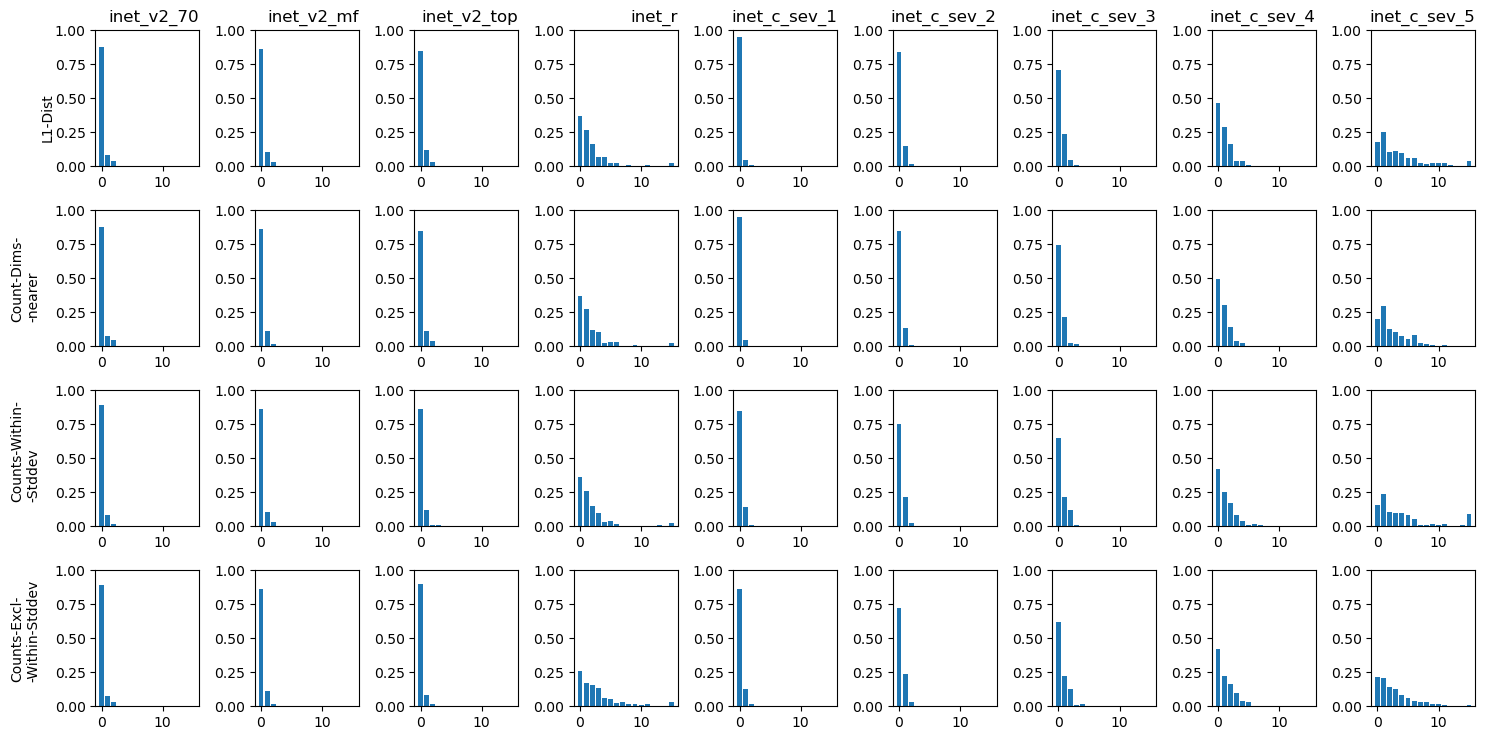

In [12]:
# count ID classes that are nearer than classA-Prime 

pat_is_inet_c = re.compile('inet_c.*')

counts_id_classes_nearer = dict()
class_b_measurements = ['l1_dist', 'count_dims_nearer', 'count_within_stddev', 'count_excl_within_stddev']
map_measure_name = {'l1_dist': 'l1_dist', 'count_dims_nearer': 'dim_nearer', 'count_excl_within_stddev': 'in_not_inet_mean'}
for class_b_measure in class_b_measurements:
    counts_id_classes_nearer[class_b_measure] = {'inet_v2_70': [[], []], 'inet_v2_mf': [[], []], 'inet_v2_top': [[], []], 'inet_r': [[], []], 
                            'inet_c_sev_1': [[], []], 'inet_c_sev_2': [[], []], 'inet_c_sev_3': [[], []], 'inet_c_sev_4': [[], []], 'inet_c_sev_5': [[], []]}
data_counts_id_classes = []

# for each method measuring nearest id-classes
for class_b_measure in class_b_measurements:
    # count id-classes that are nearer to class-a than class-a-prime
    for comb_key in stats_dict.keys():
        class_a, classes_b, class_r = comb_key

        # iterate over all made comparisons, what means all instances of class-a-prime
        for ood_dset in counts_id_classes_nearer[class_b_measure].keys():

            # first get distance of class-a-prime with this class-b-measure
            # class_a_prime_dist
            if class_b_measure == 'count_within_stddev':
                if pat_is_inet_c.fullmatch(ood_dset):
                    sev = ood_dset.split('_')[-1]
                    class_a_prime_dist = calc_inet_c_dim_std_mean(stats_dict[comb_key]['dim_std']['inet_c'], 'in_and_inet_mean', sev)
                    class_a_prime_dist += calc_inet_c_dim_std_mean(stats_dict[comb_key]['dim_std']['inet_c'], 'in_not_inet_mean', sev)
                else:
                    class_a_prime_dist = stats_dict[comb_key]['dim_std'][ood_dset]['in_and_inet_mean']
                    class_a_prime_dist += stats_dict[comb_key]['dim_std'][ood_dset]['in_not_inet_mean']
            elif class_b_measure == 'count_excl_within_stddev':
                if pat_is_inet_c.fullmatch(ood_dset):
                    sev = ood_dset.split('_')[-1]
                    class_a_prime_dist = calc_inet_c_dim_std_mean(stats_dict[comb_key]['dim_std']['inet_c'], 'in_not_inet_mean', sev)
                else:
                    class_a_prime_dist = stats_dict[comb_key]['dim_std'][ood_dset]['in_not_inet_mean']
            else:
                if pat_is_inet_c.fullmatch(ood_dset):
                    sev = ood_dset.split('_')[-1]
                    class_a_prime_dist = calc_inet_c_dist_mean(stats_dict[comb_key][map_measure_name[class_b_measure]]['inet_c'], sev)
                else:
                    class_a_prime_dist = stats_dict[comb_key][map_measure_name[class_b_measure]][ood_dset]
                
            # second compare distance of class-a-prime to all already computed distances of remaining 999 id-classes
            n_nearer = 0 
            if class_b_measure == 'l1_dist':
                while (class_a_distances['l1_dist'][class_a][n_nearer][1] < class_a_prime_dist):
                    n_nearer += 1 
                    # stop when all remaining 999 Imagenet-1k classes were compared
                    if n_nearer == len(class_a_distances['l1_dist'][class_a]):
                        break
            else:
                while (class_a_distances[class_b_measure][class_a][n_nearer][1] > class_a_prime_dist):
                    n_nearer += 1 
                    # stop when all remaining 999 Imagenet-1k classes were compared
                    if n_nearer == len(class_a_distances['l1_dist'][class_a]):
                        break 
                    
            # for this class-b-measure and for this ood-set (kind of class-a-prime) add number of id-classes nearer than class-a-prime
            counts_id_classes_nearer[class_b_measure][ood_dset][0].append(n_nearer)
            # similarly add total distance of class-a-prime
            counts_id_classes_nearer[class_b_measure][ood_dset][1].append(class_a_prime_dist)


# ----  PLOT ---- 
# dict with class-b-measures as keys, each entry holds another dict with ood-sets as keys, 
# each entry of last dict is a DataFrame with structure [(combination-key, number id-classes nearer for that combination)]

n_nearest_all = pd.Series()
# first dict
dfs_per_class_b_measurement = {'l1_dist': dict(), 'count_dims_nearer': dict(), 'count_within_stddev': dict(), 'count_excl_within_stddev': dict()}

for class_b_measure in dfs_per_class_b_measurement.keys(): 

    # for this class-b-measure collect data for all ood-sets
    for ood_dset in counts_id_classes_nearer[class_b_measure].keys():
        # data_counts_id_classes.extend(list(zip(list(stats_dict.keys()), 
        #                                         [ood_dset for i in range(len(stats_dict.keys()))], 
        #                                         counts_id_classes_nearer[class_b_measure][ood_dset][0])))

        # use a temporary DataFrame
        count_df = pd.DataFrame(data=list(zip(list(stats_dict.keys()),[ood_dset for i in range(len(stats_dict.keys()))],
                                                                                            counts_id_classes_nearer[class_b_measure][ood_dset][0])),
                                                                                columns=['comb', 'dset', 'n_nearer'])
        count_df = count_df.groupby('n_nearer').count()
        count_df.rename(columns={'comb': 'counts'}, inplace=True)
        count_df.drop(['dset'], axis=1, inplace=True) 

        max_row_index = count_df.index.max()
        df_rows_extended = pd.DataFrame(data=[0 for n in range(max_row_index + 1, 15)], columns=['counts'])
        count_df = pd.concat([count_df, df_rows_extended])
        more_equal_15 = count_df[count_df.index >= 15]
        sum_more_equal_15 = more_equal_15['counts'].sum()
        rows_removed = more_equal_15.index 
        count_df.drop(rows_removed, axis=0, inplace=True)
        count_df = pd.concat([count_df, pd.DataFrame(data=[sum_more_equal_15], columns=['counts']).set_index(pd.Index([15]))])
        count_df['n_nearer'] = count_df.index
        count_df['rel_counts'] = count_df['counts'].apply(lambda x: x / 200)
        
        
        
        # add new DataFrame to collection of all DataFrames
        dfs_per_class_b_measurement[class_b_measure][ood_dset] = count_df
        

class_b_measure = 'count_dims_nearer'
for ood_dset in counts_id_classes_nearer[class_b_measure].keys():
    print(f' --- {ood_dset} --- ')
    print(dfs_per_class_b_measurement[class_b_measure][ood_dset].head(n=20))
    print(dfs_per_class_b_measurement[class_b_measure][ood_dset].shape)

row_titles = [('L1-Dist', (-10, 0.2)), ('Count-Dims-\n-nearer', (-15, 0.2)), ('Counts-Within-\n-Stddev', (-15, 0.2)), ('Counts-Excl-\n-Within-Stddev', (-15, 0.2))]
ood_dsets = list(counts_id_classes_nearer['count_dims_nearer'].keys())
fig, axs = plt.subplots(len(dfs_per_class_b_measurement.keys()), len(ood_dsets), figsize=(15, 7.5))
for r, class_b_measure in enumerate(dfs_per_class_b_measurement.keys()):
    print(f' ### {class_b_measure} ### ')
    
    
    for c, dset in enumerate(ood_dsets):
        axs[r][c].bar(dfs_per_class_b_measurement[class_b_measure][dset]['n_nearer'].to_list(), dfs_per_class_b_measurement[class_b_measure][dset]['rel_counts'].to_list())
        axs[r][c].set_ylim((0, 1.0))
        axs[r][c].set_xlim((-1, 16))
        if r == 0:
            axs[r][c].set_title(dset, loc='right')
        if c == 0: 
            m_title =  row_titles[r][0]
            x_pos =  row_titles[r][1][0]
            y_pos = row_titles[r][1][1]
            title_measure = axs[r][c].text(x_pos, y_pos, m_title, rotation='vertical')

plt.tight_layout()
plt.savefig('/home/stud/afroehli/coding/dinov2_ood/diagrams_png/n_nearer_classes.png', bbox_inches='tight')
plt.show()

# g = sns.boxplot(data=df_counts_id_classes, x='dset', y='n_nearer', showfliers=False)
# plt.xticks(rotation=45, rotation_mode='anchor', ha='right')

In [51]:
max_n_dims = 384

# ----- DF-INET-C ----- #

# df_inet_c_data: DataFrame holding all results for Imagenet-C dataset

def get_corruption_type(cor_name: str) -> str:
    if cor_name in ['gaussian_noise', 'shot_noise', 'impulse_noise']:
        return 'noise'
    elif cor_name in ['defocus_blur', 'glass_blur', 'motion_blur', 'zoom_blur']:
        return 'blur'
    elif cor_name in ['snow', 'frost', 'brightness', 'fog']:
        return 'weather'
    elif cor_name in ['contrast', 'elastic_transform', 'pixelate', 'jpeg_compression']:
        return 'digital'
    elif cor_name in ['speckle_noise', 'spatter', 'gaussian_blur', 'saturate']:
        return 'extra'
    else:
        return 'missing'
    

df_inet_c_data = []
for comb in stats_dict.keys():
    for cor in stats_dict[comb]['dim_nearer']['inet_c'].keys():
        for sev in stats_dict[comb]['dim_nearer']['inet_c'][cor].keys():
            df_inet_c_data.append((stats_dict[comb]['dim_nearer']['inet_c'][cor][sev],
                                   stats_dict[comb]['l1_dist']['inet_c'][cor][sev],
                                   stats_dict[comb_key]['dim_std']['inet_c'][cor][sev]['in_not_inet_mean'],
                                   stats_dict[comb_key]['dim_std']['inet_c'][cor][sev]['in_and_inet_mean'],
                                   stats_dict[comb_key]['dim_std']['inet_c'][cor][sev]['not_in_and_inet_mean'],
                                   stats_dict[comb_key]['dim_std']['inet_c'][cor][sev]['not_in_not_inet_mean'],
                                    cor, sev, 'A*'))
        
df_inet_c = pd.DataFrame(data=df_inet_c_data, columns=['dim_nearer', 'l1_dist', 'in_not_inet_mean', 'in_and_inet_mean',
                                                       'not_in_not_inet_mean', 'not_in_and_inet_mean', 'cor_name', 'severity', 'Split'])

# additional transformations on inet-c DataFrame
df_inet_c = df_inet_c.assign(cor_type = lambda x : pd.Series([get_corruption_type(row['cor_name']) for _, row in x.iterrows()]))
df_inet_c = df_inet_c.assign(dim_rel=lambda x: (x['dim_nearer'] / max_n_dims) * 100)
# sort withing family of courruptions according to mean 
df_inet_c_grouped = df_inet_c.groupby('cor_name')['dim_rel'].mean().to_frame()
df_inet_c_grouped['cor_name'] = df_inet_c_grouped.index
ds_cor_mean = df_inet_c['cor_name'].apply(lambda x: df_inet_c_grouped[df_inet_c_grouped['cor_name'] == x]['dim_rel'].iloc[0])
df_inet_c['cor_mean'] = ds_cor_mean
df_inet_c = df_inet_c.sort_values(['cor_type', 'cor_mean'], ascending=False)
# get max/min values for each corruption method
group_max = df_inet_c.groupby(['cor_name'])['dim_rel'].max().to_frame()
group_min = df_inet_c.groupby(['cor_name'])['dim_rel'].min().to_frame()
group_max['cor_name'] = group_max.index 
group_min['cor_name'] = group_min.index 
y_min_per_cor = list(group_min['dim_rel'])
y_max_per_cor = list(group_max['dim_rel'])
x_cor_names = list(group_max['cor_name'])

# # calculate mean per inet-c corruption and severity
# df_grouped_cor_sev = df_inet_c.groupby(['cor_name', 'severity'])['dim_rel'].mean().to_frame()
# group_index = df_grouped_cor_sev.index
# cor_index = [cor_n for cor_n, sev in group_index]
# cor_series = pd.Series([cor_n for cor_n, sev in group_index])
# df_grouped_cor_sev = df_grouped_cor_sev.set_index(cor_series.index)
# df_grouped_cor_sev['cor_name'] = cor_series


# ----- DF-BASIC ----- #


# df_basic_data: holds all results for used datasets other than Imagenet-C
class_b_measures = ['l1_dist', 'dims_nearer', 'count_in_stddev', 'count_excl_in_stddev']

dfs_basic = dict()
for class_b_measure in class_b_measures:
    df_basic_data = []
    for dset in ['class_b', 'class_r', 'inet_v2_70', 'inet_v2_mf', 'inet_v2_top', 'inet_r']:
        if dset == 'class_b':
            split = 'B'
        elif dset == 'class_r':
            split = 'Random'
        else:
            split = 'A*'
        
        if dset == 'class_b':
            df_basic_data.extend(list(
                        zip([stats_dict[comb]['dim_nearer'][f'{dset}'][class_b_measure] for comb in stats_dict.keys()], 
                            [stats_dict[comb]['l1_dist'][f'{dset}'][class_b_measure] for comb in stats_dict.keys()], 
                            [stats_dict[comb]['dim_std'][f'{dset}'][class_b_measure]['in_not_inet_mean'] for comb in stats_dict.keys()],
                            [stats_dict[comb]['dim_std'][f'{dset}'][class_b_measure]['in_and_inet_mean'] for comb in stats_dict.keys()],
                            [stats_dict[comb]['dim_std'][f'{dset}'][class_b_measure]['not_in_and_inet_mean'] for comb in stats_dict.keys()],
                            [stats_dict[comb]['dim_std'][f'{dset}'][class_b_measure]['not_in_not_inet_mean'] for comb in stats_dict.keys()],
                            [f'{dset}' for n in stats_dict.keys()],
                            [split for _ in stats_dict.keys()])
                    ))
        else:
            df_basic_data.extend(list(
                                    zip([stats_dict[comb]['dim_nearer'][f'{dset}'] for comb in stats_dict.keys()], 
                                        [stats_dict[comb]['l1_dist'][f'{dset}'] for comb in stats_dict.keys()], 
                                        [stats_dict[comb]['dim_std'][f'{dset}']['in_not_inet_mean'] for comb in stats_dict.keys()],
                                        [stats_dict[comb]['dim_std'][f'{dset}']['in_and_inet_mean'] for comb in stats_dict.keys()],
                                        [stats_dict[comb]['dim_std'][f'{dset}']['not_in_and_inet_mean'] for comb in stats_dict.keys()],
                                        [stats_dict[comb]['dim_std'][f'{dset}']['not_in_not_inet_mean'] for comb in stats_dict.keys()],
                                        [f'{dset}' for n in stats_dict.keys()],
                                        [split for _ in stats_dict.keys()])
                                ))
    dfs_basic[class_b_measure] = pd.DataFrame(data = df_basic_data, columns = ['dim_nearer', 'l1_dist', 'in_not_inet_mean', 'in_and_inet_mean', 
                                                            'not_in_and_inet_mean', 'not_in_not_inet_mean', 'dset', 'Split'])

    # add inet-c data to general DataFrame
    df_inet_c = df_inet_c.assign(dset='inet_c')
    dfs_basic[class_b_measure] = pd.concat([dfs_basic[class_b_measure], df_inet_c[['dim_nearer', 'l1_dist', 'in_not_inet_mean', 'in_and_inet_mean',
                                                                    'not_in_not_inet_mean', 'not_in_and_inet_mean', 'dset', 'Split']]],
                                                                    ignore_index=True)
    
    # transformation of results to percentages
    dfs_basic[class_b_measure] = dfs_basic[class_b_measure].assign(dim_rel = lambda x: (x['dim_nearer'] / max_n_dims) * 100)

# new DataFrame only for data about std-deviation
dfs_melted = dict()
for class_b_measures in ['count_in_stddev', 'count_excl_in_stddev']: 
    dfs_melted[class_b_measures] = pd.melt(dfs_basic[class_b_measures], id_vars=['dset', 'Split'], value_vars=['in_not_inet_mean', 'in_and_inet_mean', 'not_in_and_inet_mean', 'not_in_not_inet_mean'],
                        value_name='n_dims', var_name='split')
    dfs_melted[class_b_measures]['n_dims_rel'] = (dfs_melted[class_b_measures]['n_dims'] / max_n_dims) * 100

# # add inet-c data to general DataFrame
# df_basic = pd.concat([df_basic, df_inet_c.assign(dset='inet_c')[['dim_nearer', 'l1_dist', 'Split']]], ignore_index=True)

# calculate Imagenet-1k L1-Mean
ds_inet_mean_l1_dist = pd.Series([stats_dict[comb]['l1_dist']['inet_mean'] for comb in stats_dict.keys()])
inet_mean_l1_dist_mean = ds_inet_mean_l1_dist.mean()




## ---- DF-Example ---- ##

all_combs = list(stats_dict.keys())
rand_combs = [all_combs[random.randrange(0, len(all_combs))] for n in range(3)]

examp_b_res = []
examp_inet_r_res = []
examp_inet_c_res = []
examp_inet_v_res = []

for r_comb in rand_combs:
    examp_b_res.append((stats_dict[r_comb]['dim_nearer']['class_b']['l1_dist'] / max_n_dims) * 100)
    examp_inet_r_res.append((stats_dict[r_comb]['dim_nearer']['inet_r'] / max_n_dims) * 100)
    examp_inet_v_res.append(((sum([stats_dict[r_comb]['dim_nearer'][f'{dset}'] for dset in ['inet_v2_70', 'inet_v2_mf', 'inet_v2_top']]) / 3) / max_n_dims) * 100)

    examp_inet_c_sum = 0
    examp_inet_c_n = 0
    for cor in inet_c_corruptions: 
        for sev in range(1, 6):
            examp_inet_c_sum += stats_dict[r_comb]['dim_nearer']['inet_c'][cor][f'sev_{sev}']
            examp_inet_c_n += 1

    examp_inet_c_res.append(((examp_inet_c_sum / examp_inet_c_n) / max_n_dims) * 100)

class_a_name = [imagenet_info.wnid_to_classname[rand_combs[n][0]] for n in range(3)]
class_b_name = [imagenet_info.wnid_to_classname[rand_combs[n][1][0]] for n in range(3)]

df_examples = []
for n in range(3):
    df_examples.append(pd.DataFrame(data=zip([examp_b_res[n], examp_inet_v_res[n], examp_inet_c_res[n], examp_inet_r_res[n]], 
                                             ['inet_1k', 'inet_v', 'inet_c', 'inet_r'], 
                                             [class_b_name[n], class_a_name[n], class_a_name[n], class_a_name[n]]),
                                             columns=['dim_nearer', 'dataset', 'Imagenet class']))




In [23]:
print(df_basic.shape)
inet_c_l1_dists = df_basic.loc[df_basic['dset'] == 'inet_c']['l1_dist']
print(inet_c_l1_dists.shape)
print(inet_c_l1_dists.mean())
print(inet_c_l1_dists.iloc[[random.randint(0, 18999) for i in range(10)]])

(20200, 9)
(19000,)
328.3941
7175     235.810486
9809     269.059052
10438    554.786255
1334     182.938995
5973     424.462708
14928    345.550171
18717    525.930847
13299    525.984497
19757    528.100281
11640    153.452728
Name: l1_dist, dtype: float32


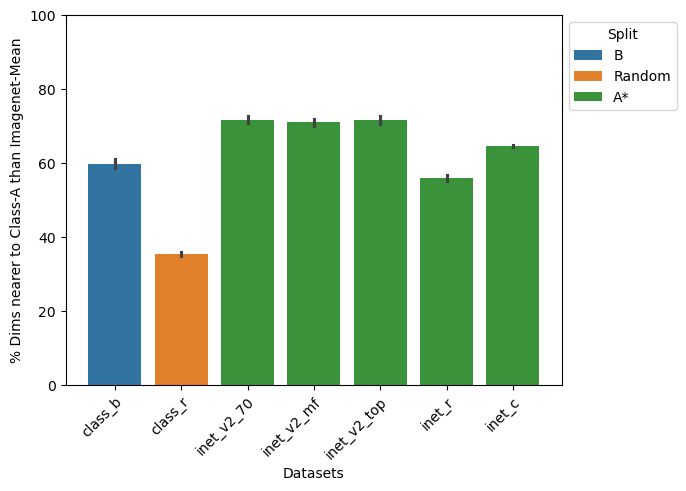

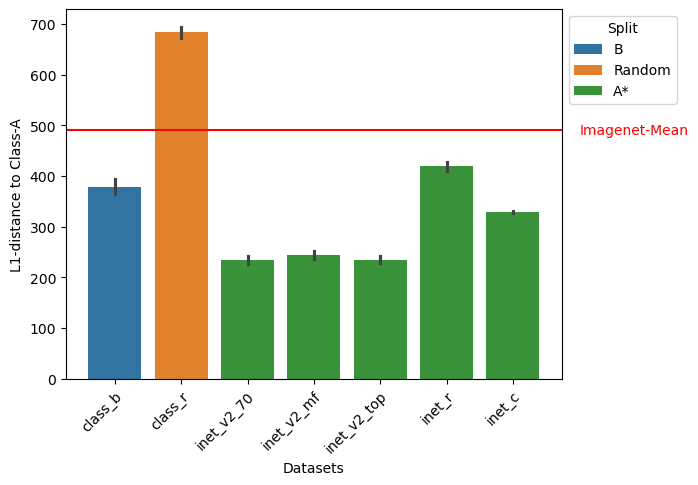

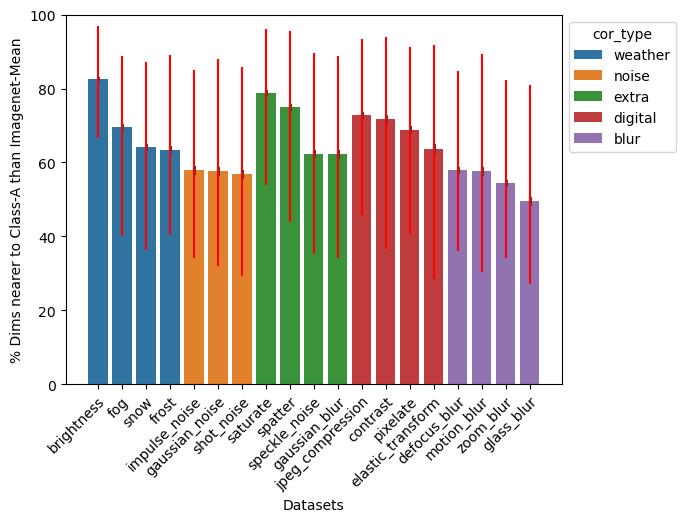

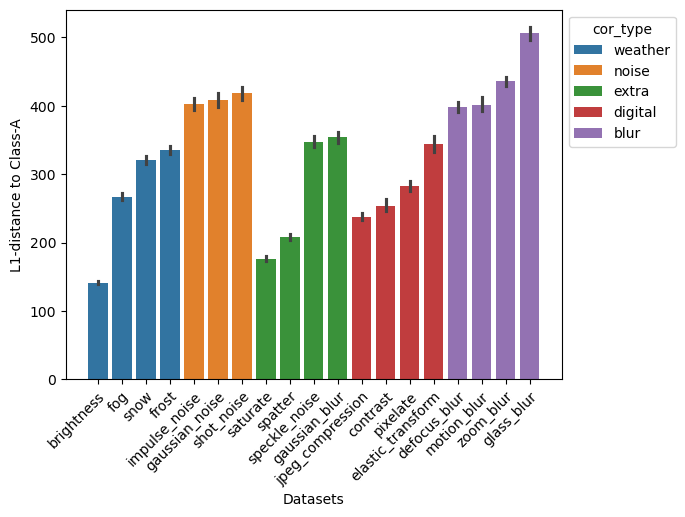

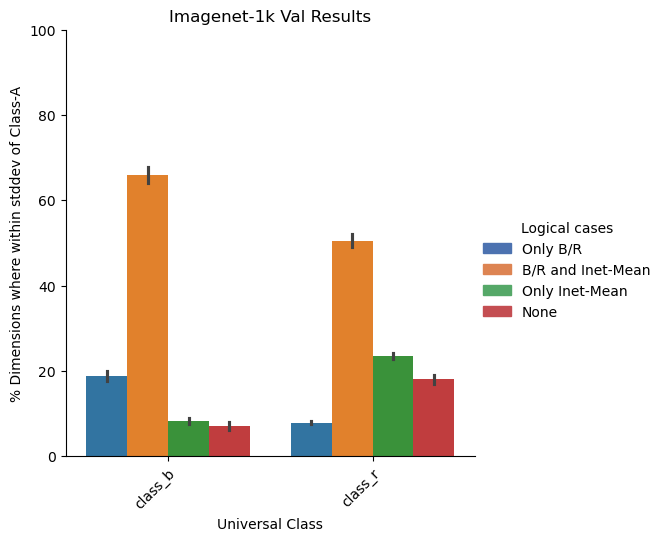

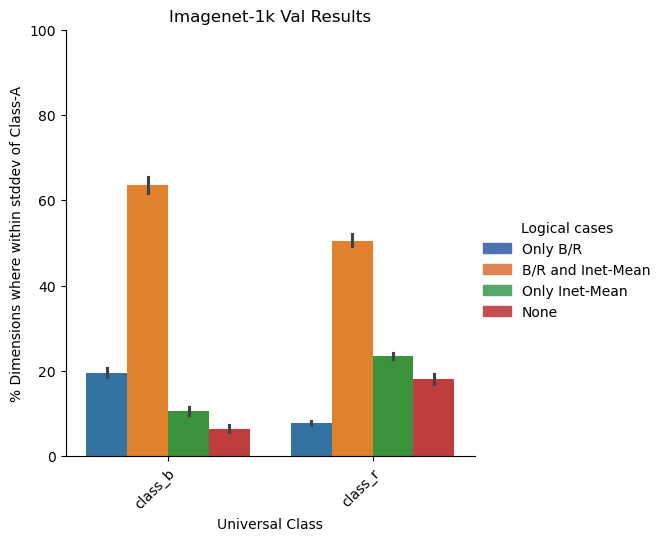

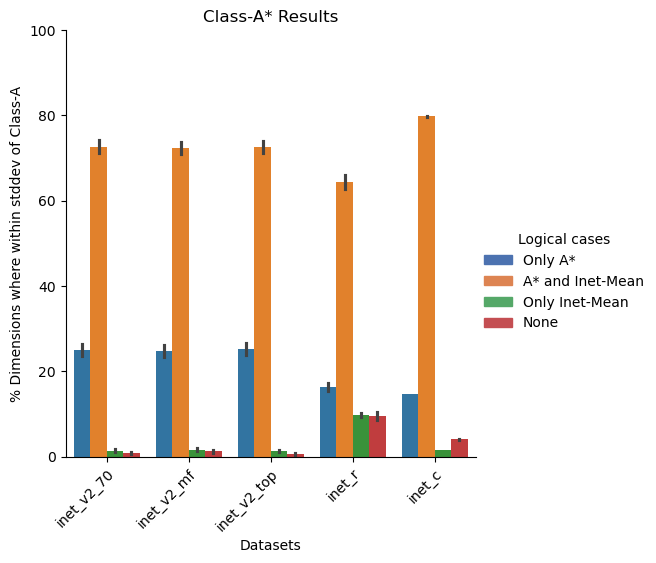

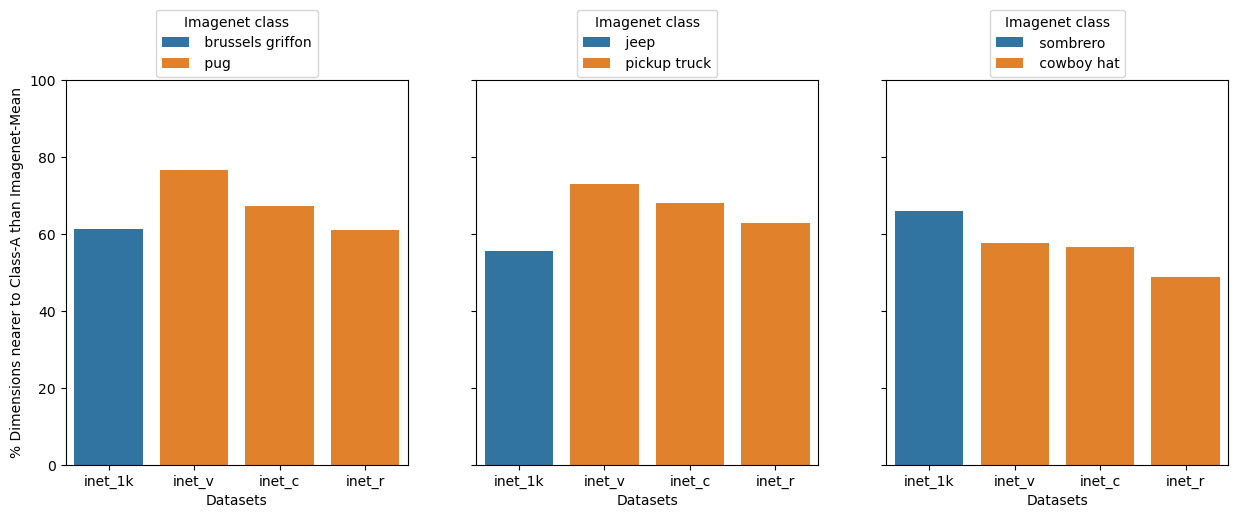

<Axes: xlabel='dataset', ylabel='dim_nearer'>

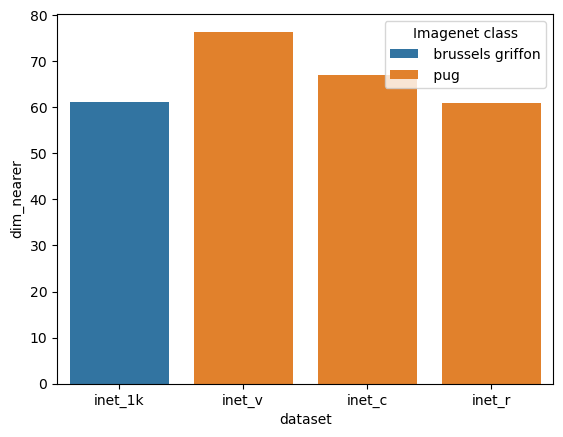

In [53]:
## ----- PLOTS ----- ##

save_dir = 'diagrams_specific'

df_basic_i_c = dfs_basic['dims_nearer'].loc[dfs_basic['dims_nearer']['dset']=='inet_c']
sns_plot = sns.barplot(data=dfs_basic['dims_nearer'], x='dset', y='dim_rel', hue='Split')
sns_plot.set(xlabel='Datasets', ylabel='% Dims nearer to Class-A than Imagenet-Mean')
sns.move_legend(sns_plot, 'upper left', bbox_to_anchor=(1,1))
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.ylim((0, 100))
plt.plot()
plt.savefig(f'/home/stud/afroehli/coding/dinov2_ood/{save_dir}/overall_dims_nearer.png', bbox_inches='tight')
plt.show()

sns_plot = sns.barplot(data=dfs_basic['l1_dist'], x='dset', y='l1_dist', hue='Split')
sns_plot.set(xlabel='Datasets', ylabel='L1-distance to Class-A')
sns.move_legend(sns_plot, 'upper left', bbox_to_anchor=(1,1))
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.axhline(y=inet_mean_l1_dist_mean, color='r')
plt.text(x=7, y=inet_mean_l1_dist_mean, verticalalignment='center', s='Imagenet-Mean', color='r')
plt.plot()
plt.savefig(f'/home/stud/afroehli/coding/dinov2_ood/{save_dir}/overall_l1_dist.png', bbox_inches='tight')
plt.show()


sns_plot = sns.barplot(data=df_inet_c, x='cor_name', y='dim_rel', hue='cor_type')
sns_plot.set(xlabel='Datasets', ylabel='% Dims nearer to Class-A than Imagenet-Mean')
sns.move_legend(sns_plot, 'upper left', bbox_to_anchor=(1,1))
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.vlines(x=x_cor_names, ymin=y_min_per_cor, ymax=y_max_per_cor, colors='red')
plt.ylim((0, 100))
plt.plot()
plt.savefig(f'/home/stud/afroehli/coding/dinov2_ood/{save_dir}/inet_c_dims_nearer.png', bbox_inches='tight')
plt.show()

sns_plot = sns.barplot(data=df_inet_c, x='cor_name', y='l1_dist', hue='cor_type')
sns_plot.set(xlabel='Datasets', ylabel='L1-distance to Class-A')
sns.move_legend(sns_plot, 'upper left', bbox_to_anchor=(1,1))
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.plot()
plt.savefig(f'/home/stud/afroehli/coding/dinov2_ood/{save_dir}/inet_c_l1_dist.png', bbox_inches='tight')
plt.show()

df_melted_class_b_r_within_stddev = dfs_melted['count_in_stddev'].loc[(dfs_melted['count_in_stddev']['dset'] == 'class_b') | (dfs_melted['count_in_stddev']['dset'] == 'class_r')]
df_melted_class_b_r_excl_within_stddev = dfs_melted['count_excl_in_stddev'].loc[(dfs_melted['count_excl_in_stddev']['dset'] == 'class_b') | (dfs_melted['count_excl_in_stddev']['dset'] == 'class_r')]
df_melted_class_a_p = dfs_melted['count_in_stddev'].loc[~((dfs_melted['count_in_stddev']['dset'] == 'class_b') | (dfs_melted['count_in_stddev']['dset'] == 'class_r'))]

log_cases_b_r = ['Only B/R', 'B/R and Inet-Mean', 'Only Inet-Mean', 'None']
log_cases_a_prime = ['Only A*', 'A* and Inet-Mean', 'Only Inet-Mean', 'None'] 
colors_b_r = sns.color_palette('deep').as_hex()[:len(log_cases_b_r)]
colors_a_prime = sns.color_palette('deep').as_hex()[:len(log_cases_a_prime)]
handles_b_r = [patches.Patch(color= col, label=lab) for col, lab in zip(colors_b_r, log_cases_b_r)]
handles_a_prime = [patches.Patch(color= col, label=lab) for col, lab in zip(colors_a_prime, log_cases_a_prime)]

# class-b just within stddev of class-a
facet_grid = sns.catplot(df_melted_class_b_r_within_stddev, kind='bar', x='dset', y='n_dims_rel', hue='split', legend=False)
facet_grid.set(xlabel='Universal Class', ylabel='% Dimensions where within stddev of Class-A')
facet_grid.add_legend(handles=handles_b_r, title='Logical cases', label_order=log_cases_b_r)
plt.ylim((0, 100))
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.title('Imagenet-1k Val Results')
plt.savefig(f'/home/stud/afroehli/coding/dinov2_ood/{save_dir}/class_b_r_within_stddev.png', bbox_inches='tight')
plt.show()
# class-b exclusively within stddev of class-a
facet_grid = sns.catplot(df_melted_class_b_r_excl_within_stddev, kind='bar', x='dset', y='n_dims_rel', hue='split', legend=False)
facet_grid.set(xlabel='Universal Class', ylabel='% Dimensions where within stddev of Class-A')
facet_grid.add_legend(handles=handles_b_r, title='Logical cases', label_order=log_cases_b_r)
plt.ylim((0, 100))
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.title('Imagenet-1k Val Results')
plt.savefig(f'/home/stud/afroehli/coding/dinov2_ood/{save_dir}/class_b_r_excl_within_stddev.png', bbox_inches='tight')
plt.show()
# remaining class-a-prime
facet_grid = sns.catplot(df_melted_class_a_p, kind='bar', x='dset', y='n_dims_rel', hue='split', legend=False)
facet_grid.set(xlabel='Datasets', ylabel='% Dimensions where within stddev of Class-A')
facet_grid.add_legend(handles=handles_a_prime, title='Logical cases', label_order=log_cases_a_prime)
plt.ylim((0, 100))
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.title('Class-A* Results')
plt.savefig(f'/home/stud/afroehli/coding/dinov2_ood/{save_dir}/class_a_prime_within_stddev.png', bbox_inches='tight')
plt.show()


fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
for n in range(3):
    sub_plot = sns.barplot(data=df_examples[n], ax=ax[n], x='dataset', y='dim_nearer', hue='Imagenet class')
    sns.move_legend(sub_plot, 'upper center', bbox_to_anchor=(0.5, 1.2))
    sub_plot.set(ylabel='% Dimensions nearer to Class-A than Imagenet-Mean', xlabel='Datasets')
    
plt.ylim((0, 100))
plt.savefig('/home/stud/afroehli/coding/dinov2_ood/diagrams_png/examples_dims_nearer.png', bbox_inches='tight')
plt.show()

sns.barplot(data=df_examples[0], x='dataset', y='dim_nearer', hue='Imagenet class')